# Optimisation numérique : comparaison du gradient (pas fixe / pas optimal / pas variable) et de la méthode de Newton

Ce notebook illustre quatres méthodes classiques d’optimisation sur la même fonction quadratique :

- Gradient à **pas fixe**
- Gradient à **pas optimal**
- Gradient à **pas variable** (backtracking / Armijo)
- Méthode de **Newton**

Nous visualiserons leurs trajectoires et comparerons leurs performances (itérations et temps d’exécution).


## Fonction à optimiser

Nous considérons la fonction quadratique convexe :

$$
f(x, y) = x^2 + 2y^2 + xy - 6x - 8y
$$

### Gradient
$$
\nabla f(x, y) =
\begin{pmatrix} 2x + y - 6 \\ x + 4y - 8 \end{pmatrix}
$$

### Hessienne (constante)
$$
H = \begin{pmatrix} 2 & 1 \\ 1 & 4 \end{pmatrix}
$$

### Minimum réel
En résolvant $\nabla f(x, y) = 0$, on obtient :

$$
(x^*, y^*) = \left(\frac{16}{7}, \frac{10}{7}\right)
$$



In [20]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Définition de la fonction et de ses dérivées
def f(X):
    x, y = X
    return x**2 + 2*y**2 + x*y - 6*x - 8*y

def grad_f(X):
    x, y = X
    df_dx = 2*x + y - 6
    df_dy = 4*y + x - 8
    return np.array([df_dx, df_dy])

def hess_f(X):
    return np.array([[2, 1],
                     [1, 4]])



## Gradient à pas fixe

L'algorithme met à jour :

$$
X_{k+1} = X_k - \alpha \nabla f(X_k)
$$

- \(\alpha\) = pas constant choisi à l'avance
- Sensible au choix du pas : trop grand → divergence ; trop petit → lenteur


In [10]:
def gradient_pas_fixe(X0, alpha=0.1, tol=1e-6, max_iter=1000):
    X = X0.copy()
    traj = [X.copy()]
    for _ in range(max_iter):
        g = grad_f(X)
        if np.linalg.norm(g) < tol:
            break
        X = X - alpha * g
        traj.append(X.copy())
    return np.array(traj)


## Gradient à pas optimal (Exact line search)

À chaque itération on choisit le pas $\alpha_k$ qui minimise exactement la fonction le long de la direction du gradient.

**Définition.** Pour le point courant $x_k$ et $g_k=\nabla f(x_k)$, on pose la fonction unidimensionnelle
$$
\varphi(\alpha)=f(x_k-\alpha\,g_k),\qquad \alpha\ge 0.
$$
Le pas optimal est
$$
\alpha_k^\ast=\arg\min_{\alpha\ge0}\varphi(\alpha)=\arg\min_{\alpha\ge0} f(x_k-\alpha g_k).
$$

**Condition d'optimalité.** Si $\varphi$ est différentiable, alors $\alpha_k^\ast$ vérifie
$$
\varphi'(\alpha_k^\ast)=0
\quad\Longleftrightarrow\quad
-\nabla f(x_k-\alpha_k^\ast g_k)^\top g_k = 0.
$$

**Cas quadratique.** Si $f(x)=\tfrac12 x^\top A x - b^\top x + c$ avec $A$ symétrique définie positive, alors
$$
\alpha_k^\ast = \frac{g_k^\top g_k}{g_k^\top A g_k},
$$
où $g_k=\nabla f(x_k)=Ax_k-b$.

**Mise à jour.**
$$
x_{k+1}=x_k-\alpha_k^\ast g_k.
$$

**Remarques courtes.**
- Le pas est calculé **à chaque itération** (recherche 1-D exacte).
- Très efficace pour les quadratiques (formule analytique), mais plus coûteux que les recherches heuristiques (Armijo).



In [11]:
def gradient_pas_optimal(X0, tol=1e-6, max_iter=1000):
    X = X0.copy()
    traj = [X.copy()]

    for _ in range(max_iter):
        g = grad_f(X)
        if np.linalg.norm(g) < tol:
            break

        # Hessienne constante pour cette fonction
        H = hess_f(X)

        # Pas optimal exact pour les fonctions quadratiques
        alpha = (g @ g) / (g @ (H @ g))

        # Mise à jour
        X = X - alpha * g
        traj.append(X.copy())

    return np.array(traj)


## Gradient à pas variable (méthode de backtracking)

On cherche un pas \(\alpha_k\) satisfaisant :

$$
f(X_k - \alpha_k g_k) \le f(X_k) - c\alpha_k \|g_k\|^2
$$

L’algorithme ajuste le pas automatiquement → plus robuste et souvent plus rapide.


In [12]:
def gradient_pas_variable(X0, alpha0=1, rho=0.5, c=1e-4, tol=1e-6, max_iter=1000):
    X = X0.copy()
    traj = [X.copy()]
    for _ in range(max_iter):
        g = grad_f(X)
        if np.linalg.norm(g) < tol:
            break
        alpha = alpha0
        # Backtracking Armijo
        while f(X - alpha*g) > f(X) - c*alpha*np.dot(g, g):
            alpha *= rho
        X = X - alpha * g
        traj.append(X.copy())
    return np.array(traj)


## Méthode de Newton

La mise à jour est :

$$
X_{k+1} = X_k - H^{-1}\nabla f(X_k)
$$

- Convergence quadratique pour les fonctions convexes
- Très rapide, mais nécessite l’inversion de la Hessienne


In [13]:
def newton_method(X0, tol=1e-6, max_iter=100):
    X = X0.copy()
    traj = [X.copy()]
    H_inv = np.linalg.inv(hess_f(X))
    for _ in range(max_iter):
        g = grad_f(X)
        if np.linalg.norm(g) < tol:
            break
        X = X - H_inv @ g
        traj.append(X.copy())
    return np.array(traj)


## Exécution des quatres méthodes

Nous lançons les trois algorithmes depuis le même point de départ et mesurons :

- Nombre d'itérations
- Temps d'exécution
- Trajectoire dans le plan


In [15]:
X0 = np.array([0.0, 0.0])

# Gradient pas fixe
start = time.time()
traj_fixed = gradient_pas_fixe(X0, alpha=0.1)
t_fixed = time.time() - start

#Gradient à pas optimal
start = time.time()
traj_optimal = gradient_pas_optimal(X0)
t_optimal = time.time() - start

# Gradient pas variable
start = time.time()
traj_variable = gradient_pas_variable(X0)
t_variable = time.time() - start

# Newton
start = time.time()
traj_newton = newton_method(X0)
t_newton = time.time() - start

print(f"Gradient pas fixe     : {len(traj_fixed)-1} itérations, temps = {t_fixed:.6f}s")
print(f"Gradient pas optimal : {len(traj_optimal)-1} itérations, temps = {t_optimal:.6f}s")
print(f"Gradient pas variable : {len(traj_variable)-1} itérations, temps = {t_variable:.6f}s")
print(f"Méthode de Newton     : {len(traj_newton)-1} itérations, temps = {t_newton:.6f}s")


Gradient pas fixe     : 86 itérations, temps = 0.002006s
Gradient pas optimal : 12 itérations, temps = 0.000000s
Gradient pas variable : 15 itérations, temps = 0.000000s
Méthode de Newton     : 1 itérations, temps = 0.000000s


### Visualisation des trajectoires des différentes méthodes du gradient en 2D

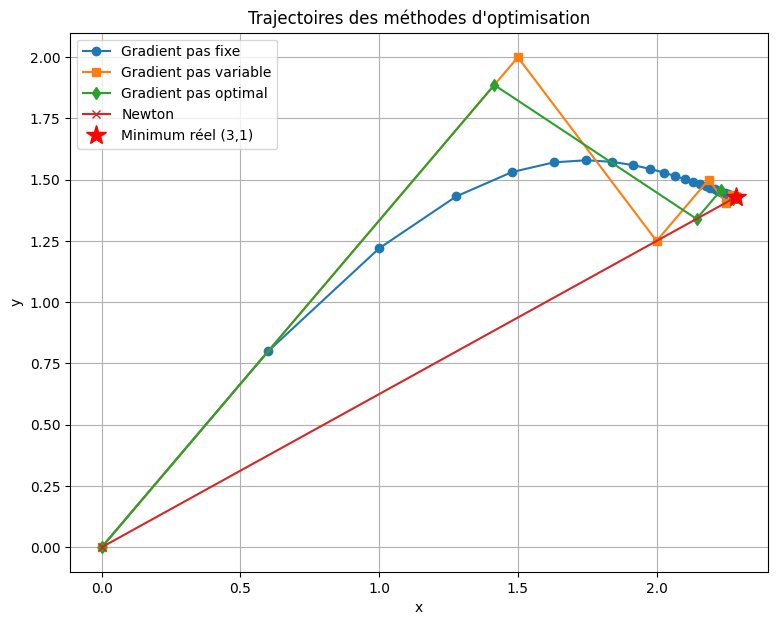

In [21]:
plt.figure(figsize=(9,7))
plt.plot(traj_fixed[:,0], traj_fixed[:,1], 'o-', label='Gradient pas fixe')
plt.plot(traj_variable[:,0], traj_variable[:,1], 's-', label='Gradient pas variable')
plt.plot(traj_optimal[:,0], traj_optimal[:,1], 'd-', label='Gradient pas optimal')
plt.plot(traj_newton[:,0], traj_newton[:,1], 'x-', label='Newton')

# Minimum réel
plt.plot(16/7, 10/7, 'r*', markersize=15, label='Minimum réel (3,1)')

plt.xlabel("x")
plt.ylabel("y")
plt.title("Trajectoires des méthodes d'optimisation")
plt.legend()
plt.grid(True)
plt.show()


### Visualisation en 3D

In [22]:
import plotly.graph_objects as go
import numpy as np

# Grille pour la surface
x = np.linspace(-1, 5, 100)
y = np.linspace(-1, 5, 100)
X, Y = np.meshgrid(x, y)

# Fonction quadratique
Z = X**2 + 2*Y**2 + X*Y - 6*X - 8*Y

# Création de la surface 3D
surface = go.Surface(x=X, y=Y, z=Z, colorscale='Viridis', opacity=0.7, name='Surface')

# Fonction pour créer une trace pour chaque trajectoire
def create_traj_trace(traj, label, color):
    traj_X = [p[0] for p in traj]
    traj_Y = [p[1] for p in traj]
    traj_Z = [p[0]**2 + 2*p[1]**2 + p[0]*p[1] - 6*p[0] - 8*p[1] for p in traj]
    return go.Scatter3d(x=traj_X, y=traj_Y, z=traj_Z,
                        mode='lines+markers',
                        marker=dict(size=4),
                        line=dict(width=4, color=color),
                        name=label)

# Traces des 4 méthodes
trace_fixed = create_traj_trace(traj_fixed, 'Gradient pas fixe', 'red')
trace_variable = create_traj_trace(traj_variable, 'Gradient pas variable', 'green')
trace_optimal = create_traj_trace(traj_optimal, 'Gradient pas optimal', 'blue')
trace_newton = create_traj_trace(traj_newton, 'Newton', 'magenta')

# Minimum réel
min_x, min_y = 16/7, 10/7  # adapter selon la fonction
min_z = min_x**2 + 2*min_y**2 + min_x*min_y - 6*min_x - 8*min_y
min_trace = go.Scatter3d(x=[min_x], y=[min_y], z=[min_z],
                         mode='markers', marker=dict(size=6, color='black'),
                         name='Minimum réel')

# Figure
fig = go.Figure(data=[surface, trace_fixed, trace_variable, trace_optimal, trace_newton, min_trace])

fig.update_layout(scene=dict(
                    xaxis_title='x',
                    yaxis_title='y',
                    zaxis_title='f(x,y)'),
                  width=900, height=700,
                  title="Trajectoires des méthodes d'optimisation (interactive 3D)")

fig.show()


# Conclusion

- **Gradient à pas fixe**
  - Simple mais sensible au choix du pas
  - Convergence lente
---
- **Gradient à pas optimal**
  - Très efficace sur les fonctions quadratiques, et peu adapté aux fonctions non-quadratiques
  - Convergence plus rapide que le pas fixe
  - Plus coûteux que le pas variable
---
- **Gradient à pas variable**
  - Beaucoup plus robuste que le pas fixe
  - Convergence plus rapide
---
- **Méthode de Newton**
  - Ultra-rapide pour une fonction quadratique
  - Convergence en très peu d’itérations
  - Coût plus élevé pour des problèmes de grande dimension

